<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/bench_cody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# gpu demo for cody

In [1]:
# !pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11 cudf-cu11 cugraph-cu11 pylibraft_cu11 raft_dask_cu11 dask_cudf_cu11 pylibcugraph_cu11 pylibraft_cu11
# import cuml,cudf
# print(cuml.__version__)

# !wget https://www.dropbox.com/s/owzp6af8v4vcp1s/sample-state-with-severity.csv.zip
# !unzip sample-state-with-severity.csv.zip

# !pip install -U --force git+https://github.com/graphistry/pygraphistry.git@cudf
# !pip install -U git+https://github.com/graphistry/cu-cat.git@DT
# !pip install dirty_cat 
# !pip install umap-learn

# !nvidia-smi --query-gpu=gpu_name --format=csv
# !pip install nvsmi

In [2]:
import cuml,cudf
print(cuml.__version__)


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject


23.04.01


In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
import os
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pstats import Stats
import cudf
from time import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 200)

In [5]:
import graphistry
graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='fXjJnkE3Gik6BWy') ## key id, secret key

# graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__

import cu_cat
print(cu_cat.__file__)

/usr/local/lib/python3.10/dist-packages/cu_cat/__init__.py


In [6]:
# !nvidia-smi --query-gpu=gpu_name --format=csv
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader
# !nvidia-smi -L
# import sys
# import os

# gpu=(sys.argv[1])
# gpu
import os

Tesla T4


In [7]:
import nvsmi
gpu=str(nvsmi.get_gpu_processes()).split('|')[3].split(':')[1]

In [91]:
filtered_df=pd.read_csv("sample-state-with-severity.csv").drop(columns=["Unnamed: 0"])
samp=filtered_df.sample(500000)

from graphistry.features import ModelDict, topic_model

X = ['DRUG_NAME',"severity_level",'BUYER_BUS_ACT',"BUYER_COUNTY","BUYER_STATE"] #buyer_state and county only for multi states

# samp['feats'] = samp[X].astype(str).agg(' '.join, axis=1)
samp['month_date']=pd.to_datetime(samp['month_date'])
samp['day'] = samp['month_date'].dt.day
samp['month'] = samp['month_date'].dt.month
samp['year'] = samp['month_date'].dt.year

sampA=samp.drop(columns=['month_date','ds'])

for j,d in enumerate(pd.unique(sampA.DRUG_NAME)):
    samp=sampA[sampA['DRUG_NAME']==d]
    if samp.shape[0]<35000:
        g = graphistry.nodes(cudf.from_pandas(samp))
        t=time()
        g2=g.featurize(feature_engine='cu_cat',memoize=True)
        t1=time()-t
        t=time()
        g2.umap(X=X, engine='cuml')
        t2=time()-t
        
        pd.DataFrame([['gpu',d,t1,t2,samp.shape[0]]]).to_csv('bench3.txt',mode='a',sep='\t',index=None,header=None)
        
        g = graphistry.nodes((samp))
        t=time()
        g3=g.featurize(feature_engine='dirty_cat',memoize=True)
        t3=time()-t
        t=time()
        # try:
        g.umap(X=X, feature_engine='dirty_cat', engine='umap_learn')
        # except:
            # pass
        t4=time()-t
        pd.DataFrame([['cpu',d,t3,t4,samp.shape[0]]]).to_csv('bench3.txt',mode='a',sep='\t',index=None,header=None)

Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat
Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat


Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Using GPU: dirty_cat


In [22]:
data=pd.read_csv('bench3.txt',sep='\t',header=None)
data.columns=['drug','cu_cat','cuml','dirty_cat','cpu','dims']

In [23]:
data['umap_learn']=data.cpu-data.dirty_cat
data['gpu']=data.cu_cat+data.cuml

In [160]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp *.txt /content/drive/MyDrive/graphistry/

In [132]:
data=pd.read_csv('bench2.txt',sep='\t',names=['drug','cu_cat','cuml','dirty_cat','cpu','dims'])

RR=data[7:].sort_values(by='cpu',ascending=False)#.to_csv('drug_bench.txt',sep='\t',index=False)
RR['drug_count']= RR.drug+'_'+RR.dims.str.split(',').str[0].str.strip('(')
RR['umap_learn']=RR.cpu-RR.dirty_cat
RR.drop(columns=['drug','dims','cpu'],inplace=True)


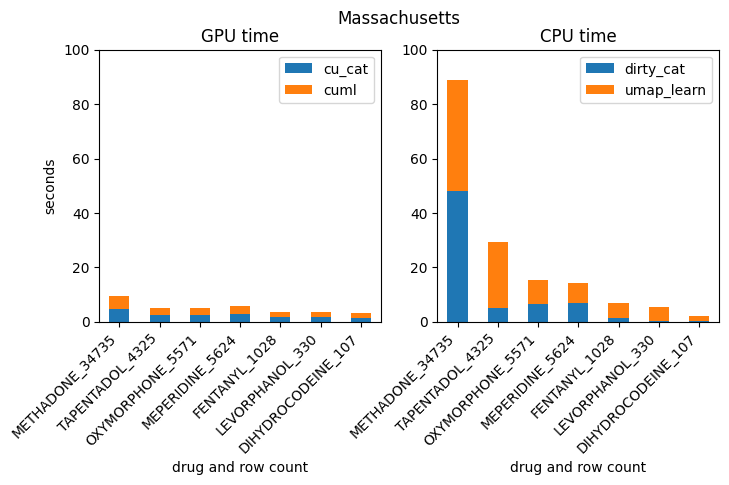

In [159]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8, 4))

RR.index=RR['drug_count']
RR[['drug_count','cu_cat','cuml']].plot.bar(ax=axes[0],stacked=True)
RR[['drug_count','dirty_cat','umap_learn']].plot.bar(ax=axes[1],stacked=True)

axes[0].set_ylim([0, 100])
axes[0].set_title('GPU time')
axes[0].set_ylabel('seconds')
axes[0].set_xlabel('drug and row count')

axes[1].set_ylim([0, 100])
axes[1].set_title('CPU time')
axes[1].set_xlabel('drug and row count')
fig.suptitle('Massachusetts')
fig.autofmt_xdate(rotation=45)